In [2]:
import torch
import torch_geometric_temporal

# print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
# print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print(f"PyTorch Geometric Temporal version: {torch_geometric_temporal.__version__}")

PyTorch version: 2.4.1+cu124
PyTorch Geometric Temporal version: 0.54.0


In [3]:
import sys
import pkg_resources

packages = [
    'torch',
    'torch_geometric',
    'torch_geometric_temporal',
    'pandas',
    'matplotlib'
]

print(f"Python version: {sys.version}")

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package} version: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package} is not installed")

# Additional PyTorch info
if 'torch' in sys.modules:
    import torch
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")

Python version: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]
torch version: 2.4.1+cu124
torch_geometric version: 2.3.0
torch_geometric_temporal version: 0.54.0
pandas version: 1.3.5
matplotlib version: 3.9.2
CUDA available: True
CUDA version: 12.4


C:\Users\chatu\AppData\Local\Temp\ipykernel_2232\1482004660.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split


# need to downgrade torch-geometric from 2.6 to 2.3


In [5]:
dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)

In [6]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [7]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

In [8]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h



In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric_temporal.nn.recurrent import GConvGRU

# class TemporalGNN(nn.Module):
#     def __init__(self, node_features, hidden_features):
#         super(TemporalGNN, self).__init__()
#         self.recurrent = GConvGRU(node_features, hidden_features, 2)
#         self.linear = nn.Linear(hidden_features, 1)
#         self.dropout = nn.Dropout(0.2)  # Note the correct spelling here

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight)
#         h = self.dropout(h)  # And here
#         h = self.linear(h)
#         return h

In [10]:
model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)


In [12]:
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# model.train()
# for epoch in range(10):
#     loss = 0
#     for i, snapshot in enumerate(train_dataset):
#         y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#         loss = loss + torch.mean((y_pred - snapshot.y)**2)
#     loss = loss/(i+1)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

# model.eval()
# loss = 0
# for i, snapshot in enumerate(test_dataset):
#     y_pred = model(snapshot.x, snapshot.edge_index,
#     snapshot.edge_attr)
#     mse = torch.mean((y_pred-snapshot.y)**2)
#     loss += mse
#     loss = loss / (i+1)
#     print(f'MSE: {loss.item():.4f}')


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in range(1000):
    total_loss = 0
    for i, snapshot in enumerate(train_dataset):
        optimizer.zero_grad()  # Reset gradients at the start of each batch
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred - snapshot.y)**2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

model.eval()
test_loss = 0
with torch.no_grad():  # No need to track gradients during evaluation
    for i, snapshot in enumerate(test_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        mse = torch.mean((y_pred - snapshot.y)**2)
        test_loss += mse.item()

avg_test_loss = test_loss / (i + 1)
print(f'Test MSE: {avg_test_loss:.4f}')

Epoch 1, Average Loss: 0.8314
Epoch 2, Average Loss: 0.9492
Epoch 3, Average Loss: 0.8575
Epoch 4, Average Loss: 0.8341
Epoch 5, Average Loss: 0.8448
Epoch 6, Average Loss: 0.8194
Epoch 7, Average Loss: 0.8034
Epoch 8, Average Loss: 0.8296
Epoch 9, Average Loss: 0.7870
Epoch 10, Average Loss: 0.8738
Epoch 11, Average Loss: 0.7944
Epoch 12, Average Loss: 0.7693
Epoch 13, Average Loss: 0.7887
Epoch 14, Average Loss: 0.7656
Epoch 15, Average Loss: 0.7738
Epoch 16, Average Loss: 0.7614
Epoch 17, Average Loss: 0.7806
Epoch 18, Average Loss: 0.7486
Epoch 19, Average Loss: 0.7460
Epoch 20, Average Loss: 0.7484
Epoch 21, Average Loss: 0.7560
Epoch 22, Average Loss: 0.7534
Epoch 23, Average Loss: 0.7491
Epoch 24, Average Loss: 0.7466
Epoch 25, Average Loss: 0.7850
Epoch 26, Average Loss: 0.7628
Epoch 27, Average Loss: 0.7564
Epoch 28, Average Loss: 0.7236
Epoch 29, Average Loss: 0.7089
Epoch 30, Average Loss: 0.7402
Epoch 31, Average Loss: 0.7324
Epoch 32, Average Loss: 0.7029
Epoch 33, Average

Text(0, 0.5, 'Mean normalized number of cases')

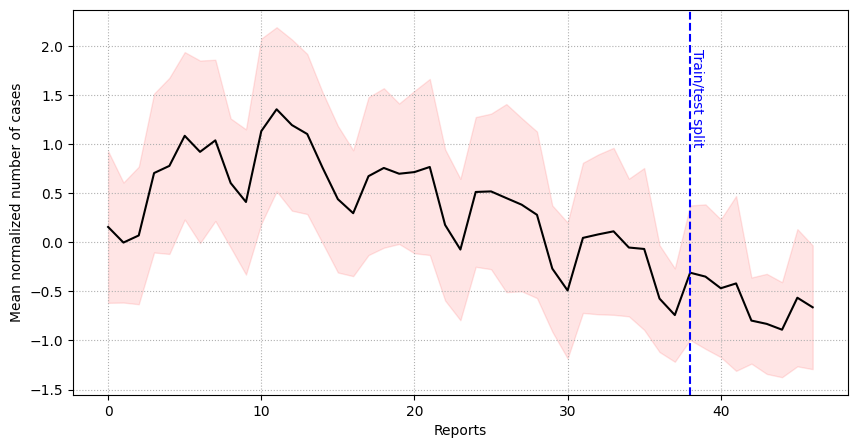

In [13]:
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

Text(0, 0.5, 'Mean normalized number of cases')

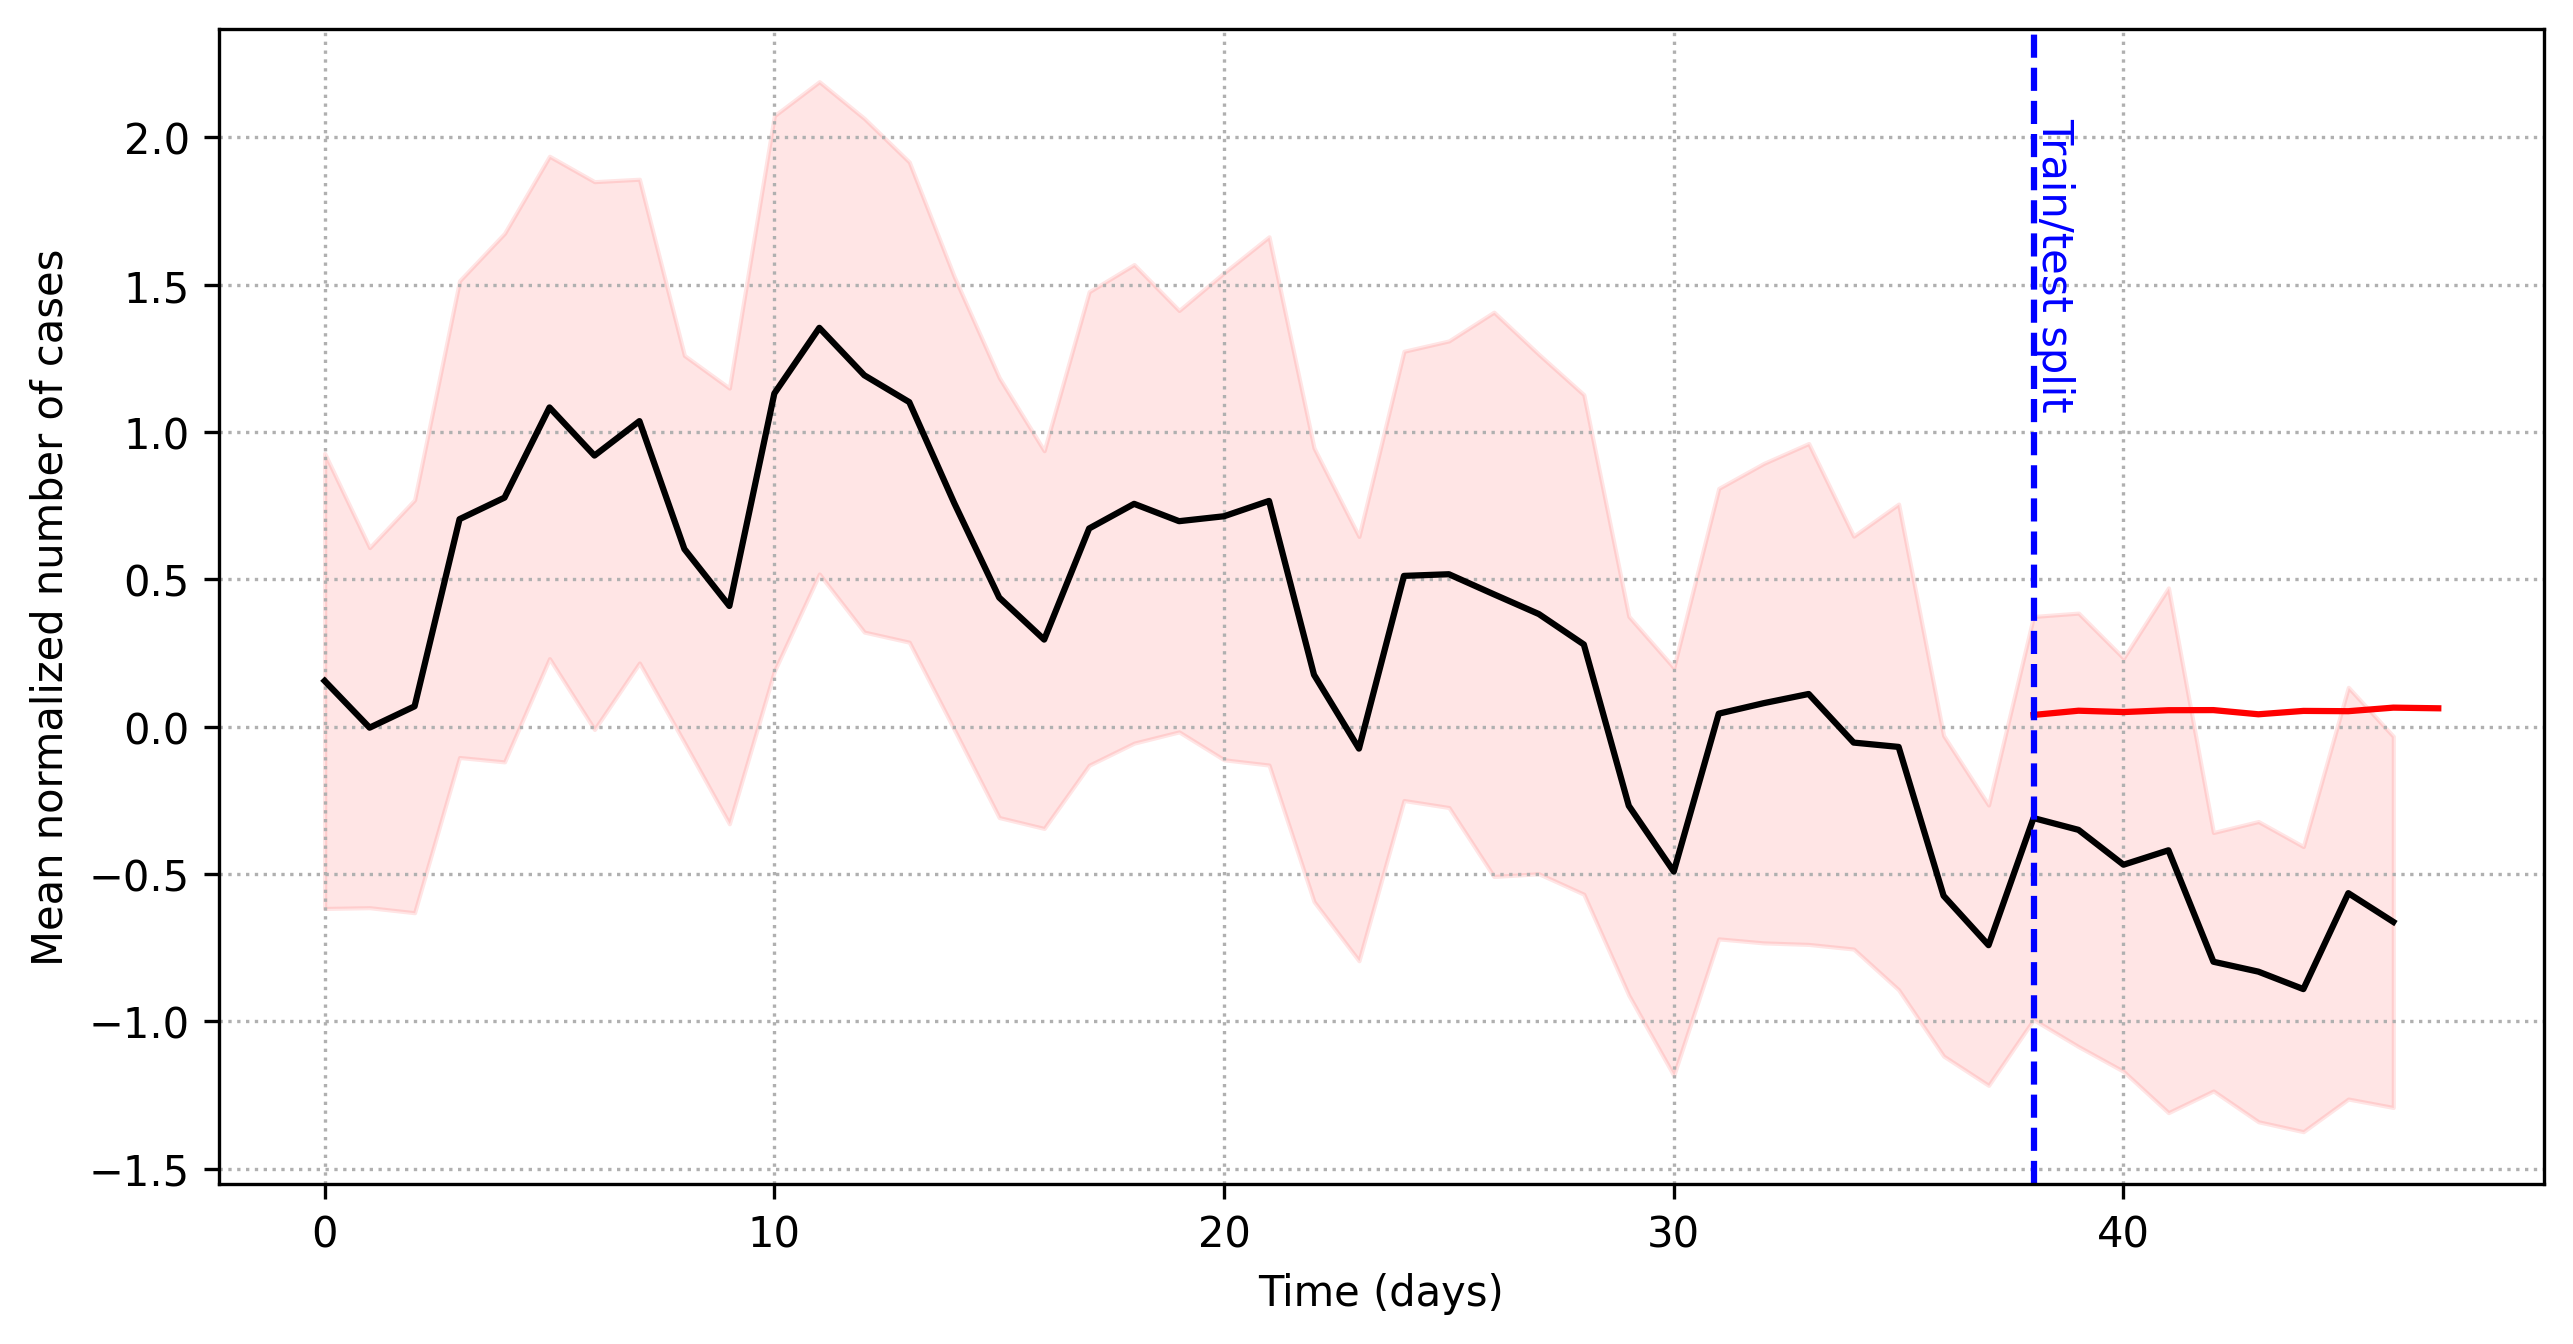

In [14]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

<Axes: >

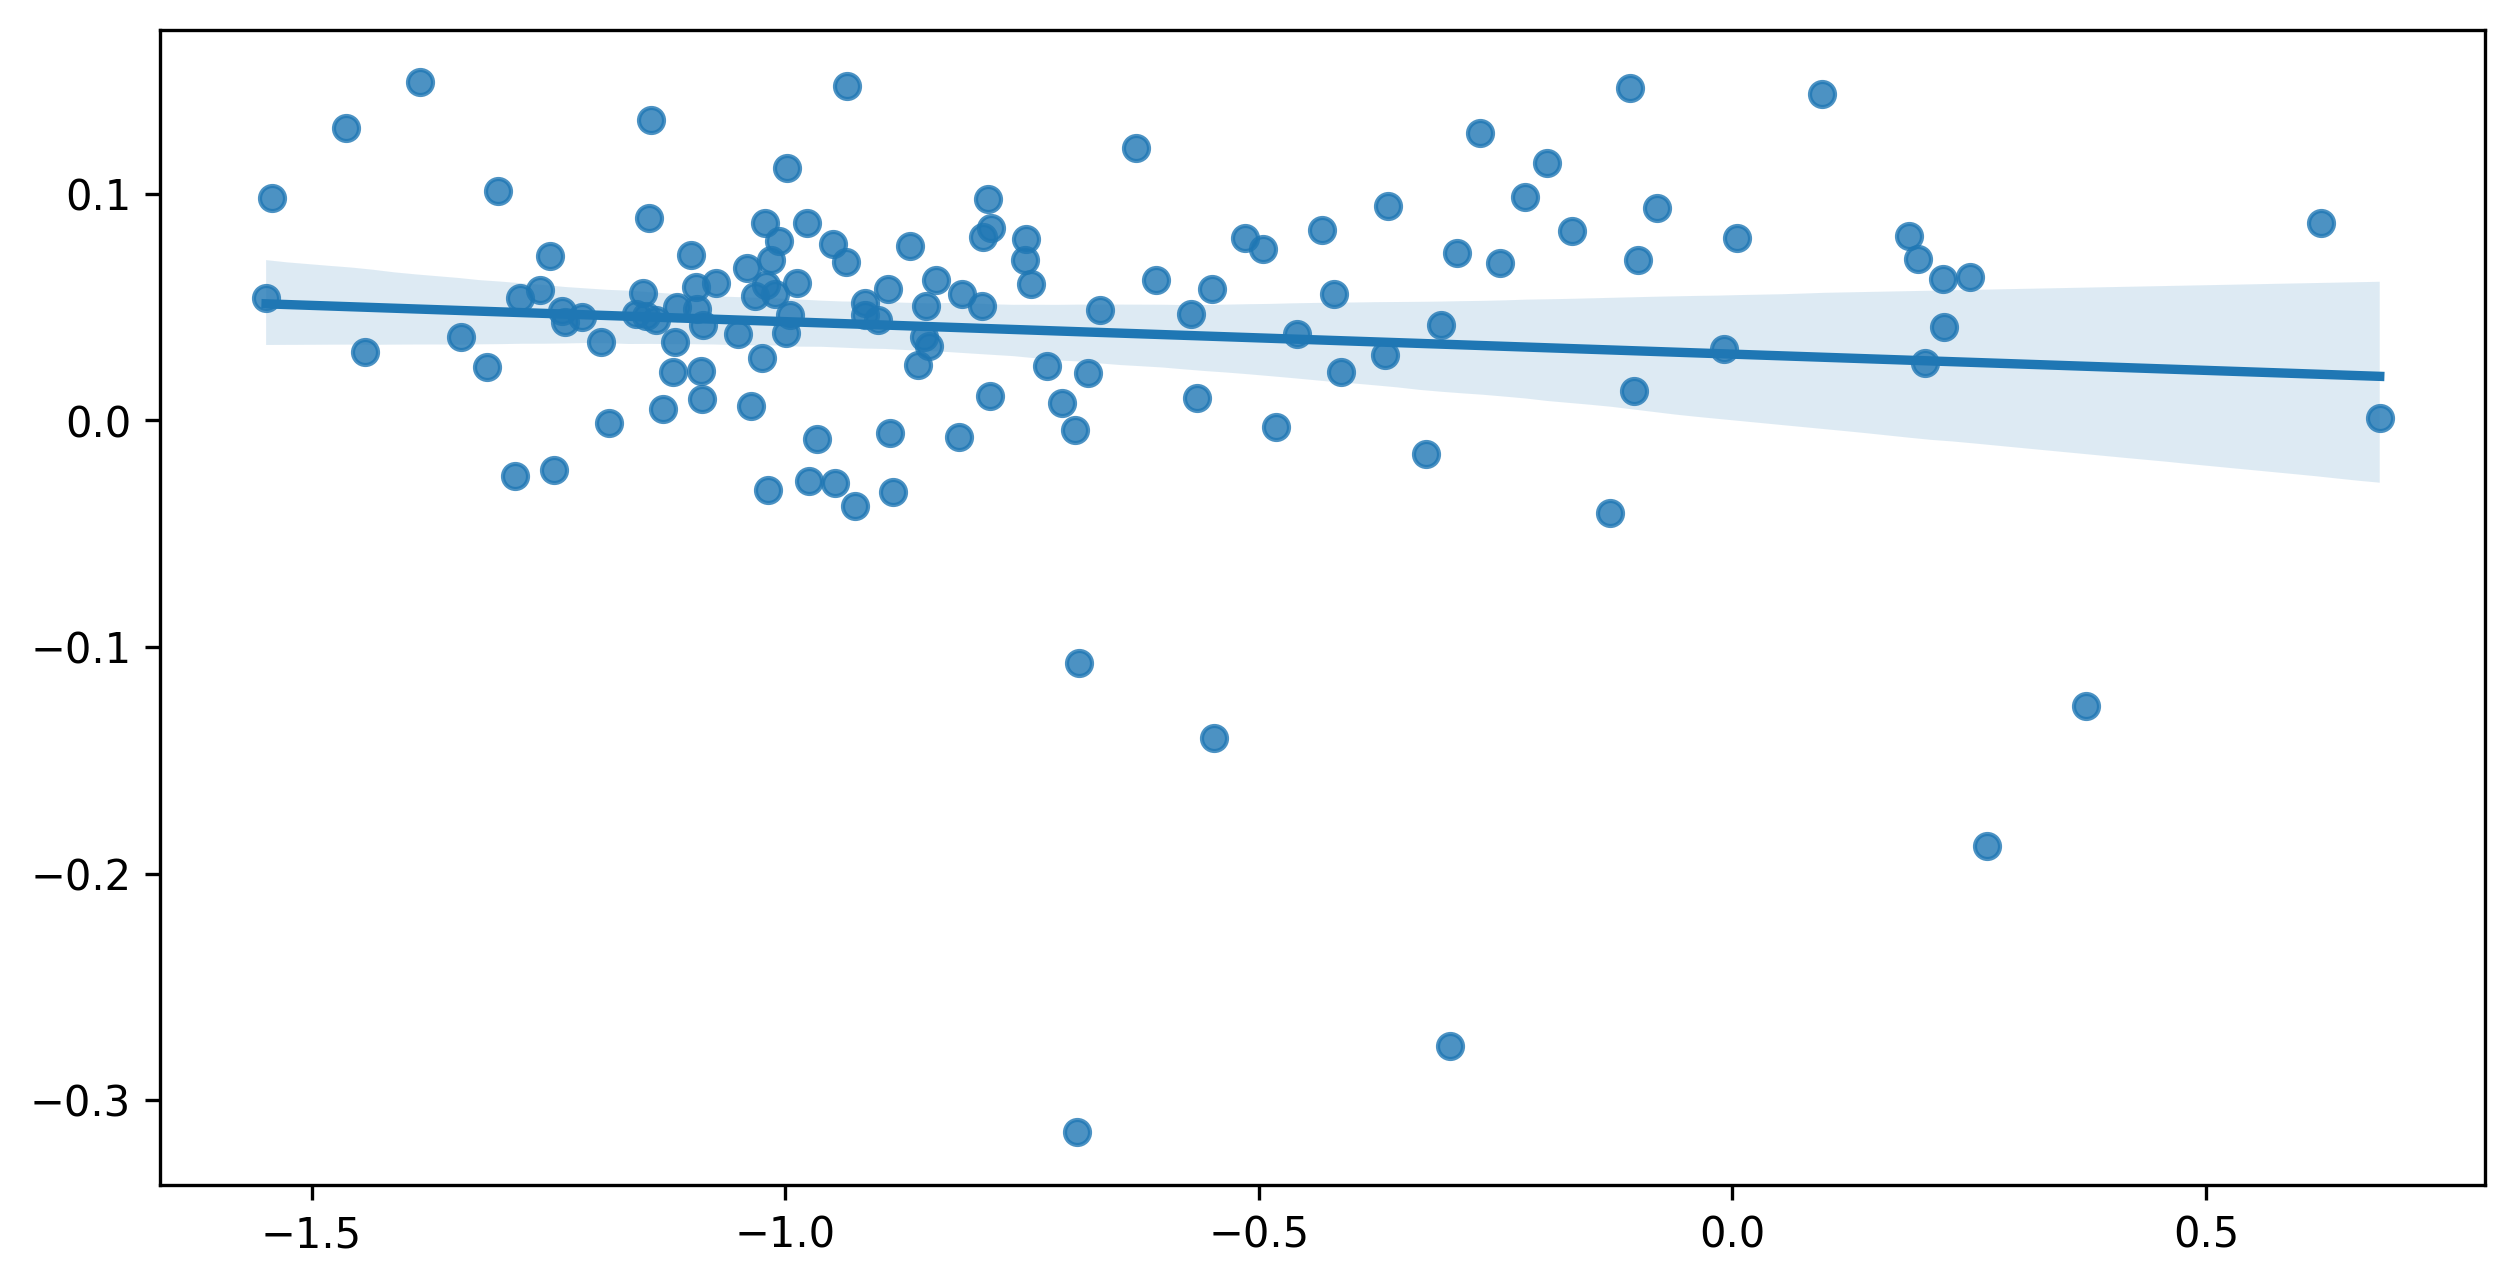

In [16]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)